# Example usage of the ACCESS-NRI catalog

The premise of the ACCESS-NRI catalog is to provide a ("meta") catalog of ("sub") catalogs, which each correspond to different "experiments". 

The idea is that users will:
 - query on metadata shared across the different subcatalogs to find the experiments that interest them
 - open those subcatalogs (which may have different/additional metadata than the outer catalog)
 - query further on the subcatalog(s) and eventually load some data

Examples are given below.

In [1]:
import intake

metacat = intake.cat.accessnri

We now have ~3 PB of data at our fingertips

In [2]:
metacat

,model,description,realm,frequency,variable
name,,,,,
HI_CN_05,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with phosphorus limitation disabled within CASA-CNP","[atmos, ocean, seaIce]","[1day, 1mon, 1yr, 3hr, 6hr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
HI_C_05_r1,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with nitrogen and phosphorus limitations disabled within CASA-CNP","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
HI_nl_C_05_r1,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with nitrogen and phosphorus limitations disabled within CASA-CNP, and land-use change disabled","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
HI_noluc_CN_05,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with phosphorus limitation disabled within CASA-CNP, and land-use change disabled","[atmos, ocean, seaIce]","[1day, 1mon, 1yr, 3hr, 6hr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
...,...,...,...,...,...
cosima_1deg_jra55_iaf_omip2_cycle4,ACCESS-OM2,Cycle 4/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019),"[ocean, seaIce]","[1day, 1mon, 1yr, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, TLAT, TLON, Tair_m, Tsfc_m, ULAT, ULON, adic, age_global, agm, aice, aice_m, aicen_m, aiso_bih, albice_m, albsni_m, albsno_m, alidf_ai_m, alidr_ai_m, alk, alvdf_ai_..."
cosima_1deg_jra55_iaf_omip2_cycle5,ACCESS-OM2,Cycle 5/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019),"[ocean, seaIce]","[1day, 1mon, 1yr, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, TLAT, TLON, Tair_m, Tsfc_m, ULAT, ULON, adic, age_global, agm, aice, aice_m, aicen_m, aiso_bih, albice_m, albsni_m, albsno_m, alidf_ai_m, alidr_ai_m, alk, alvdf_ai_..."
cosima_1deg_jra55_iaf_omip2_cycle6,ACCESS-OM2,Cycle 6/6 of 1 degree ACCESS-OM2-BGC global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019),"[ocean, seaIce]","[1day, 1mon, 1yr, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, TLAT, TLON, Tair_m, Tsfc_m, ULAT, ULON, adic, age_global, agm, aice, aice_m, aicen_m, aiso_bih, albice_m, albsni_m, albsno_m, alidf_ai_m, alidr_ai_m, alk, alvdf_ai_..."
cosima_1deg_jra55_ryf9091_gadi,ACCESS-OM2,1 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991),"[ocean, seaIce]","[1mon, 1yr, fx]","[ANGLE, ANGLET, HTE, HTN, NCAT, TLAT, TLON, Tair_m, Tsfc_m, ULAT, ULON, age_global, aice_m, aicen_m, albice_m, albsni_m, albsno_m, alidf_ai_m, alidr_ai_m, alvdf_ai_m, alvdr_ai_m, area_t, area_u, a..."


We can search on the columns in this catalog

In [3]:
metacat2 = metacat.search(model="ACCESS-ESM1-5")
metacat2

,model,description,realm,frequency,variable
name,,,,,
HI_CN_05,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with phosphorus limitation disabled within CASA-CNP","[atmos, ocean, seaIce]","[1day, 1mon, 1yr, 3hr, 6hr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
HI_C_05_r1,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with nitrogen and phosphorus limitations disabled within CASA-CNP","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
HI_nl_C_05_r1,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with nitrogen and phosphorus limitations disabled within CASA-CNP, and land-use change disabled","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
HI_noluc_CN_05,ACCESS-ESM1-5,"Historical run using same configuration as CMIP6 ACCESS-ESM1.5 historical r1i1p1f1, but with phosphorus limitation disabled within CASA-CNP, and land-use change disabled","[atmos, ocean, seaIce]","[1day, 1mon, 1yr, 3hr, 6hr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
...,...,...,...,...,...
PI_GWL_B2050,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, starting in 2050","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
PI_GWL_B2055,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, starting in 2055","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
PI_GWL_B2060,ACCESS-ESM1-5,"Climate stabilization run at different global warming levels with zero C02 emissions and pre-industrial aerosols, starting in 2060","[atmos, ocean, seaIce]","[1day, 1mon, 1yr]","[ANGLE, ANGLET, NCAT, TLAT, TLON, Tsfc, ULAT, ULON, VGRDi, VGRDs, adic, age_global, agm_grid_scaling, aice, aicen, alk, anompb, arag_raw, area_t, area_u, atm_co2, average_DT, average_T1, average_T..."
cmip6_fs38,ACCESS-ESM1-5,Australian CMIP6-era datasets catalogued by NCI,"[atmos, land, ocean, seaIce, unknown]","[1day, 1mon, 1yr, 3hr, 6hr, fx]","[agessc, arag, areacella, areacello, baresoilFrac, basin, bigthetao, bigthetaoga, c3PftFrac, c4PftFrac, cCwd, cLand, cLeaf, cLitter, cProduct, cRoot, cSoil, cSoilFast, cSoilMedium, cSoilSlow, cVeg..."


We can combine queries in a search

In [4]:
metacat3 = metacat.search(model="ACCESS-ESM1-5", variable=["tas", "tos"], frequency="1mon")
metacat3

,model,description,realm,frequency,variable
name,,,,,
cmip6_fs38,ACCESS-ESM1-5,Australian CMIP6-era datasets catalogued by NCI,"[atmos, ocean]",1mon,"[tas, tos]"


This makes for quite a useful data-discovery tool

E.g. for the CMIP6 intake-esm catalogs which contain lots of models

In [5]:
metacat.search(name="cmip6_oi10")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"[ACCESS-OM2, ACCESS-OM2-025, AWI-CM-1-1-MR, AWI-ESM-1-1-LR, BCC-CSM2-HR, BCC-CSM2-MR, BCC-ESM1, CAMS-CSM1-0, CAS-ESM2-0, CESM1-1-CAM5-CMIP5, CESM1-CAM5-SE-HR, CESM1-CAM5-SE-LR, CESM2, CESM2-FV2, C...",Replicated CMIP6-era datasets catalogued by NCI,"[atmos, land, landIce, ocean, seaIce, unknown]","[1day, 1hr, 1mon, 1yr, 3hr, 6hr, fx, subhr]","[areacella, areacello, areacellr, baresoilFrac, basin, burntFractionAll, cCwd, cLand, cLeaf, cLitter, cLitterAbove, cLitterBelow, cLitterCwd, cLitterSubSurf, cLitterSurf, cMisc, cOther, cProduct, ..."


You can see that only one model is available with the variable `burntFractionAll`:

In [6]:
metacat.search(name="cmip6_oi10", variable="burntFractionAll")

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,EC-Earth3-Veg,Replicated CMIP6-era datasets catalogued by NCI,land,1mon,burntFractionAll


We can also use regex strings in our searches. For example, we could find all the variables containing the substrings "burnt" and "Fire"

In [7]:
metacat.search(name="cmip6_oi10", variable=[".*burnt.*", ".*Fire.*"])

,model,description,realm,frequency,variable
name,,,,,
cmip6_oi10,"[AWI-ESM-1-1-LR, CESM2, CESM2-FV2, CESM2-WACCM, CESM2-WACCM-FV2, CNRM-ESM2-1, E3SM-1-1, E3SM-1-1-ECA, EC-Earth3-Veg, EC-Earth3-Veg-LR, GFDL-ESM4, MPI-ESM-1-2-HAM, MPI-ESM1-2-LR, MRI-ESM2-0, NorCPM...",Replicated CMIP6-era datasets catalogued by NCI,"[land, unknown]",1mon,"[burntFractionAll, cTotFireLut, fFire, fFireAll, fFireNat]"


**Don't forget, this is a catalog of catalogs**

Once we've sufficiently refined our search, we can load the subcatalog(s) (which for now are all intake-esm catalogs)

In [8]:
subcat = metacat.search(name="cosima_025deg_jra55_iaf_omip2_cycle1").to_subcatalog()

subcat

,unique
path,1830
realm,2
variable,315
frequency,4
...,...
variable_cell_methods,5
filename,1470
file_id,8
derived_variable,0


This will look familiar to you if you've use intake-esm catalogs before. We can see what datasets are available within this subcatalog

In [9]:
subcat.keys()

['iceh.1mon',
 'iceh_daily.1day',
 'ocean_budget.1yr',
 'ocean_daily.1day',
 'ocean_grid.fx',
 'ocean_month.1mon',
 'ocean_scalar.1mon',
 'ocean_scalar_snapshot.1day']

We can also search in this intake-esm subcatalog in the same way as we did in the metacatalog. You can read the intake-esm documentation [here](https://intake-esm.readthedocs.io/en/stable/index.html).

In [10]:
subcat2 = subcat.search(filename="ocean_scalar*")

subcat2.keys()

['ocean_scalar.1mon', 'ocean_scalar_snapshot.1day']

Great, this scalar ocean data at monthly and daily frequency is the data we've been looking for. Now we're ready to load and analyse it so let's start a dask cluster

In [11]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

Open the data into a dictionary of xarray Datasets and plot

In [12]:
ds_dict = subcat2.to_dataset_dict(progressbar=False)

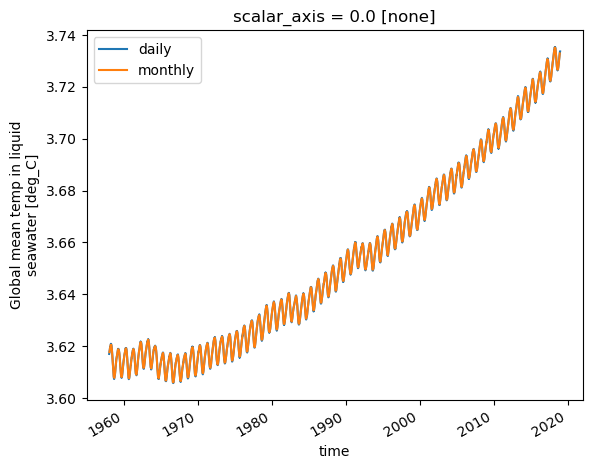

In [13]:
import matplotlib.pyplot as plt

ds_dict["ocean_scalar_snapshot.1day"]["temp_global_ave"].plot(label="daily")
ds_dict["ocean_scalar.1mon"]["temp_global_ave"].plot(label="monthly")

_ = plt.legend()

Subcatalogs can also be opened by accessing them directly as attribues or keys on the metacatalog.

(Note, the former only works if the catalog name uses only letters, numbers and underscores)

In [14]:
subcat = metacat.cosima_025deg_jra55_iaf_omip2_cycle1
subcat = metacat["cosima_025deg_jra55_iaf_omip2_cycle1"]

Additional subcatalog metadata is stored in the `metadata` attribute of each subcatalog

In [15]:
subcat.metadata

{'contact': 'Ryan Holmes',
 'created': datetime.date(2020, 11, 3),
 'email': 'ryan.holmes@unsw.edu.au',
 'keywords': ['quarter',
  'cosima',
  'access-om2-025',
  'jra55-do-v1.4.0',
  'iaf',
  'omip2'],
 'long_description': '0.25 degree ACCESS-OM2 global model configuration under interannual forcing. ACCESS-OM2-025 physics-only contribution to the CMIP6 Ocean Model Intercomparison Program project phase 2 (OMIP-2), as discussed by Tsujino et al. (2020, GMD, https://doi.org/10.5194/gmd-2019-363). The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. However, the WOA potential temperature field is converted to Conservative Temperature for the initical condition unlike earlier versions of ACCESS-OM2. The topography has also been updated (see https://github.com/COSIMA/access-om2/issues/158). Run with JRA55-do v1.4.0 interannually-var

## Another example workflow

Let's compare SST fields from three experiments:
- ACCESS-OM2, `1deg_jra55_iaf_omip2_cycle1`
- ACCESS-ESM1.5, `HI-C-05-r1`
- ACCESS-CM2, `bx944`

First we'll search directly for the experiments we're interested in and get the (intake-esm) subcatalogs for those experiments

In [16]:
metacat4 = metacat.search(name=["cosima_1deg_jra55_iaf_omip2_cycle1", "HI_C_05_r1", "bx944"])

In [17]:
subcat_dict = metacat4.to_subcatalog_dict()

subcat_dict

{'cosima_1deg_jra55_iaf_omip2_cycle1': <cosima_1deg_jra55_iaf_omip2_cycle1 catalog with 11 dataset(s) from 2013 asset(s)>,
 'bx944': <bx944 catalog with 7 dataset(s) from 12150 asset(s)>,
 'HI_C_05_r1': <HI_C_05_r1 catalog with 11 dataset(s) from 7873 asset(s)>}

Now we'll search on monthly SST within each subcatalog and load each monthly SST dataset into an xarray Dataset

In [18]:
xarray_open_kwargs = dict(
    use_cftime=True,
)
xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal", 
    coords="minimal",
)
    
ds_dict = {
    name: subcat.search(
        realm="ocean",
        variable="sst",
        frequency="1mon"
    ).to_dask(
        xarray_open_kwargs=xarray_open_kwargs, 
        xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
    )
    for name, subcat in subcat_dict.items()
}

Now we can plot our data

In [19]:
def plot_time(ds_dict, time):
    """ Plot monthly SST at a provided time """
    nrows = len(ds_dict)
    fig = plt.figure(figsize=(8, nrows*3))
    axs = fig.subplots(nrows,1)
    fig.suptitle(f'Monthly SST, {time}')
    
    for idx, (name, ds) in enumerate(ds_dict.items()):
        ax = axs[idx]
        if "member" in ds.dims:
            ds = ds.isel(member=0)
        data = ds["sst"].sel(time=time).compute()
        if (data > 273.15).any().item():
            data -= 273.15
        data.plot(ax=ax, cmap="viridis", vmin=-2, vmax=30)
        ax.set_title(name)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    fig.tight_layout()

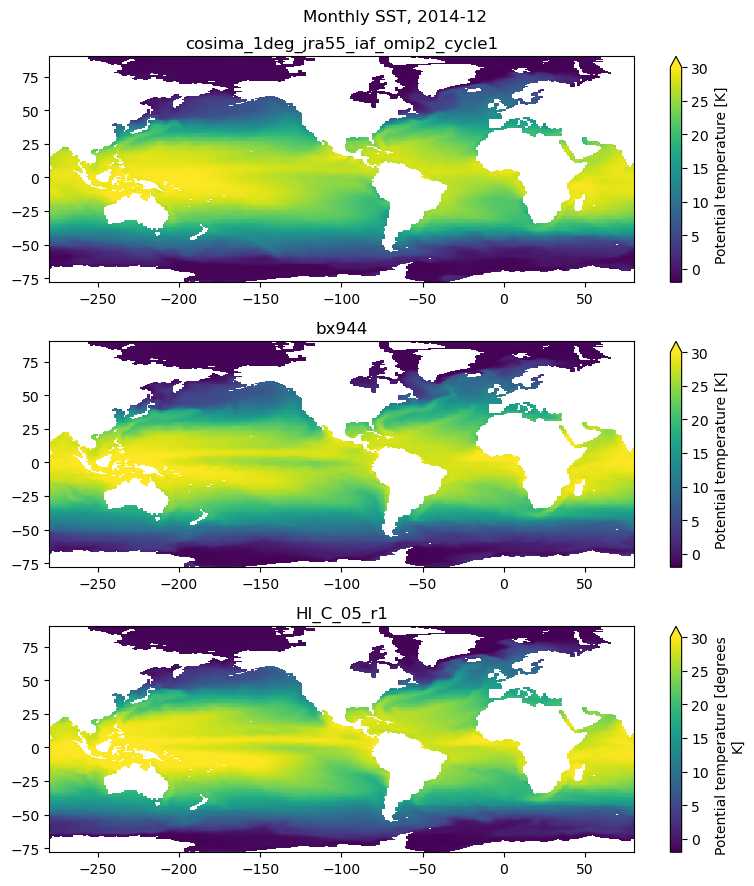

In [20]:
plot_time(ds_dict, time="2014-12")

Actually, I think I also want to add some CMIP6 data. That's easy because the NCI CMIP6 Intake catalogs are already included in our metacatalog (as are a bunch of other intake catalogs - have a browse and see).

In [21]:
cmip_subcat = metacat.search(name="cmip6_fs38").to_subcatalog()

In [22]:
ds = cmip_subcat.search(
    source_id="ACCESS-ESM1-5", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    member_id="r1i1p1f1",
    file_type="f"
).to_dask()

ds_dict["CMIP6 ACCESS-ESM1.5 historical"] = ds.rename({"tos": "sst"})

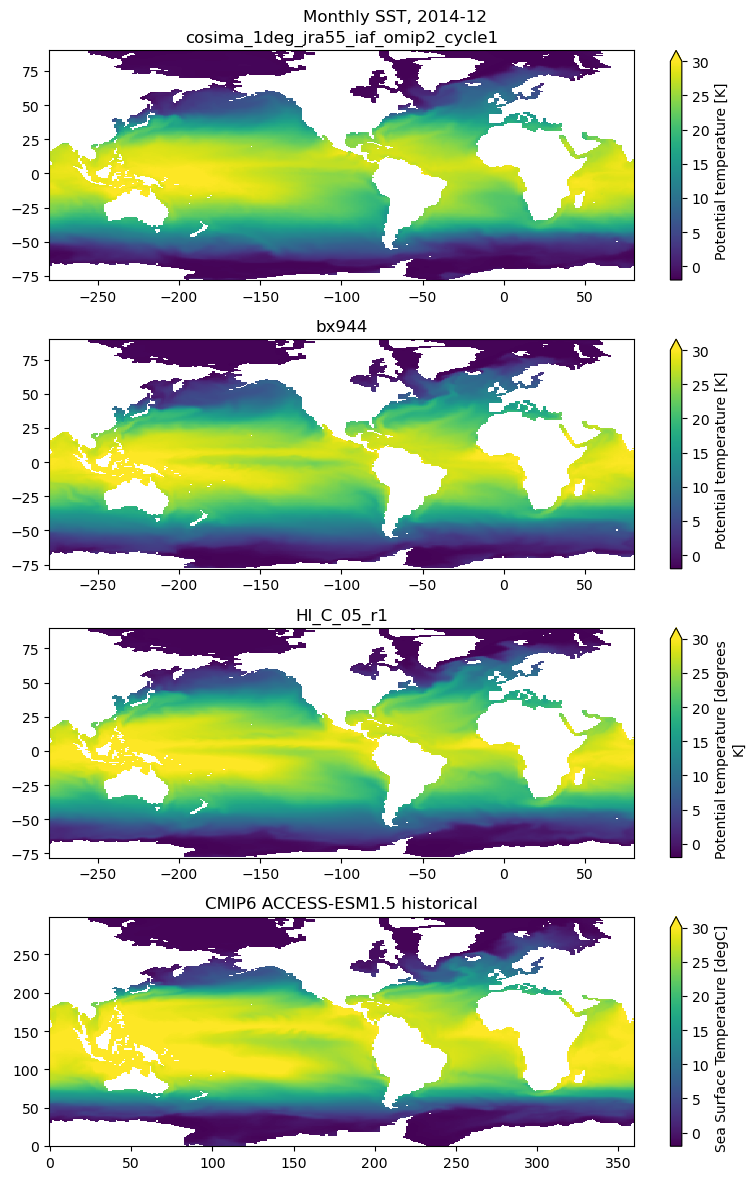

In [23]:
plot_time(ds_dict, time="2014-12")

In [24]:
client.close()